# 3D Algorithm Simulation

Includes:

- A 3D room simulation to model recording signals in a real environment
- A variety of implementations of (2D) beamforming algorithms based on the recorded data

(may want room sim in 2D, giving the advantage of building, recording, and processing the data all at once)

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from pyroomacoustics.directivities import (
    DirectivityPattern,
    DirectionVector,
    CardioidFamily,
)

### Build Theatre Environment

Create shoebox room of similar size and characteristics to theatre to simulate in.

In [31]:
# build theatre env here

fs = 44100 # audio sampling frequency

room_x = 10 # stage width
room_y = 20 # room length
room_z = 10 # room height

m = pra.make_materials(
    ceiling="hard_surface",
    floor="stage_floor",
    east="brickwork",
    west="brickwork",
    north="brickwork",
    south="brickwork",
) # materials of each surface of room, defines signal absorption

room = pra.ShoeBox([room_x, room_y, room_z], fs=fs, materials=m, max_order=10, air_absorption=True, ray_tracing=False)

### Place microphones and sound sources 

Defines array geometry and places the microphones near the stage (the front of the room). Sources can be placed anywhere, but a simple source is created at the broadside for now.

In [32]:
# Helper function to add a uniform, linear array of cardioid microphones to a room
# defined with mics along x axis, facing positive y

def ULA_cardioid(center_pos, n_mics, sep):

    # define cardioid directivity pattern
    dir_obj = CardioidFamily(
    orientation=DirectionVector(azimuth=90, colatitude=None, degrees=True),
    pattern_enum=DirectivityPattern.CARDIOID,
    )

    # determine microphone positions based on input data
    center_x = center_pos[0]
    center_y = center_pos[1]
    center_z = center_pos[2]

    array_len = (n_mics-1) * sep # length of entire mic array
    array_min = center_x - array_len/2
    array_max = center_x + array_len/2
    mic_x = np.linspace(array_min, array_max, n_mics)

    mic_locs = [mic_x, [center_y] * n_mics, [center_z] * n_mics]

    # build array
    room.add_microphone_array(mic_locs, directivity=dir_obj)

In [33]:
# Create a linear array beamformer with the following design parameters
array_loc = [5, 15, 3] # x/y/z location of array center
n_mics = 8 # number of microphones
sep = 0.05 # microphone separation

ULA_cardioid(array_loc, n_mics, sep) # build array

# Add sources on stage
source_locs = [[5, 18, 3]] # locations of each source in 3D space (can modify)

for s in source_locs:
    room.add_source(s)

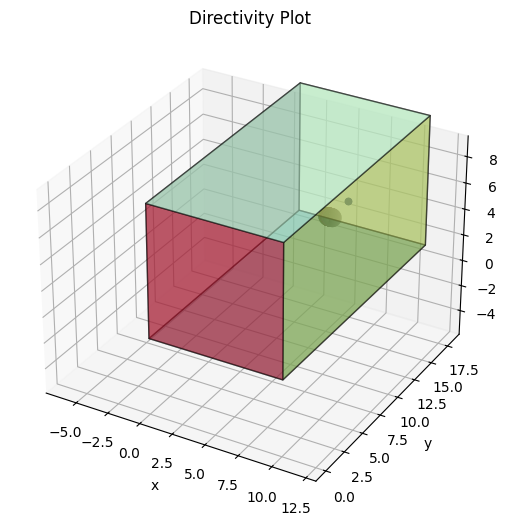

In [34]:
# Plot room to verify correctness
fig, ax = room.plot(no_axis=True)
ax.axis('equal')
plt.show()

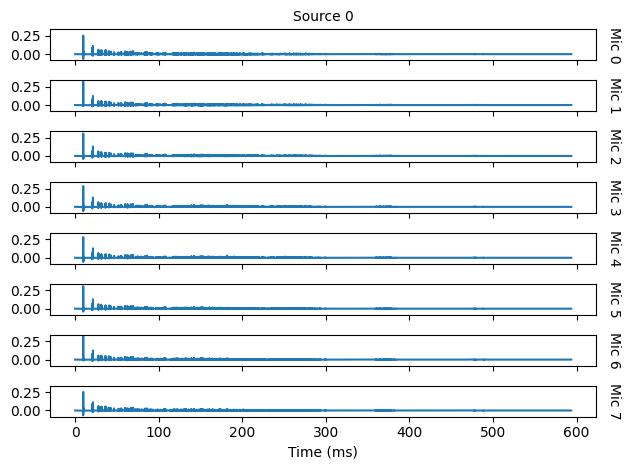

In [35]:
# Plot room impulse response
room.plot_rir()
plt.show()

## Simulations

### 1. Beamforming
Draw the beam pattern of the array